In [17]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact
import os
import csv
import pandas as pd

In [18]:
def fingerprint_segmentation(path):

    #Step 1: Fingerprint Segmentation
    fingerprint=cv.imread(path, cv.IMREAD_GRAYSCALE)
    show(fingerprint, f'Fingerprint with Size (w, h): {fingerprint.shape[::-1]} ')
    
    #calculate the local gradient (using sobel filters)
    gx, gy=cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)
    show((gx, 'Gx'), (gy, 'Gy'))

    #calculate the magnitude of the gradient for each pixel
    gx2, gy2 = gx**2, gy**2
    gm = np.sqrt(gx2 + gy2)
    show((gx2, 'Gx**2'), (gy2, 'Gy**2'), (gm, 'Gradient magnitude'))

    # Integral over a square window
    sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
    show(sum_gm, 'Integral of the gradient magnitude')

    # Use a simple threshold for segmenting the fingerprint pattern
    thr = sum_gm.max() * 0.1
    mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
    show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))
    return fingerprint, gx, gy, gx2, gy2, mask

In [19]:
def estimate_local_orientation(fingerprint, gx, gy, gx2, gy2, mask):
    #Step 2: Estimation of local ridge Orientation
    W = (23, 23)
    gxx = cv.boxFilter(gx2, -1, W, normalize = False)
    gyy = cv.boxFilter(gy2, -1, W, normalize = False)
    gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
    gxx_gyy = gxx - gyy
    gxy2 = 2 * gxy

    orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
    sum_gxx_gyy = gxx + gyy
    strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
    show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')
    return orientations, mask

In [20]:
def estimate_local_frequency(fingerprint, mask):
    region = fingerprint[100:188,100:156]
    show(region)

    # before computing the x-signature, the region is smoothed to reduce noise
    smoothed = cv.blur(region, (5,5), -1)
    xs = np.sum(smoothed, 1) # the x-signature of the region
    print(xs)

    x = np.arange(region.shape[0])
    f, axarr = plt.subplots(1,2, sharey = True)
    axarr[0].imshow(region,cmap='gray')
    axarr[1].plot(xs, x)
    axarr[1].set_ylim(region.shape[0]-1,0)
    plt.show()

    # Find the indices of the x-signature local maxima
    local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

    x = np.arange(region.shape[0])
    plt.plot(x, xs)
    plt.xticks(local_maxima)
    plt.grid(True, axis='x')
    plt.show()

    # Calculate all the distances between consecutive peaks
    distances = local_maxima[1:] - local_maxima[:-1]
    print(distances)

    # Estimate the ridge line period as the average of the above distances
    ridge_period = np.average(distances)
    print(ridge_period)
    return(ridge_period)

In [21]:
def enhance_fingerprint(fingerprint, ridge_period, orientations, mask):
    # Create the filter bank
    or_count = 8
    gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]
    show(*gabor_bank)

    # Filter the whole image with each filter
    # Note that the negative image is actually used, to have white ridges on a black background as a result
    nf = 255-fingerprint
    all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])
    show(nf, *all_filtered)

    y_coords, x_coords = np.indices(fingerprint.shape)
    # For each pixel, find the index of the closest orientation in the gabor bank
    orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
    # Take the corresponding convolution result for each pixel, to assemble the final result
    filtered = all_filtered[orientation_idx, y_coords, x_coords]
    # Convert to gray scale and apply the mask
    enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
    show(fingerprint, enhanced)    
    return(enhanced)

In [22]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [23]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

In [24]:
def follow_ridge_and_compute_angle(x, y, nd_lut, cn_values, cn, xy_steps, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None
    

In [25]:

def Gs(t_sqr, mcc_sigma_s):
    """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
    return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

def Psi(v, mcc_tau_psi, mcc_mu_psi):
    """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
    return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))
    

In [26]:
def detect_minutiae(fingerprint, enhanced, mask):
    # Binarization
    _, ridge_lines = cv.threshold(enhanced, 32, 255, cv.THRESH_BINARY)
    show(fingerprint, ridge_lines, cv.merge((ridge_lines, fingerprint, fingerprint)))

    # Thinning
    skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
    show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

    # Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
    cn_filter = np.array([[  1,  2,  4],
                        [128,  0,  8],
                        [ 64, 32, 16]
                        ])
    
    # Create a lookup table that maps each byte value to the corresponding crossing number
    all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
    cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

    # Skeleton: from 0/255 to 0/1 values
    skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
    # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
    cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0

    # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
    minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

    show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))

    # A 1-pixel background border is added to the mask before computing the distance transform
    mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
    show(mask, mask_distance)

    filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))

    show(draw_minutiae(fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))

    r2 = 2**0.5 # sqrt(2)

    # The eight possible (x, y) offsets with each corresponding Euclidean distance
    xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

    # LUT: for each 8-neighborhood and each previous direction [0,8], 
    #      where 8 means "none", provides the list of possible directions
    nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

    valid_minutiae = []
    for x, y, term in filtered_minutiae:
        d = None
        if term: # termination: simply follow and compute the direction        
            d = follow_ridge_and_compute_angle(x, y)
        else: # bifurcation: follow each of the three branches
            dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
            if len(dirs)==3: # only if there are exactly three branches
                angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
                if all(a is not None for a in angles):
                    a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                    d = angle_mean(a1, a2)                
        if d is not None:
            valid_minutiae.append( (x, y, term, d) )

    show(draw_minutiae(fingerprint, valid_minutiae))
    return valid_minutiae



In [27]:
def analyze_local_structures(valid_minutiae, fingerprint):
    # Compute the cell coordinates of a generic local structure
    mcc_radius = 75
    mcc_size = 20

    g = 2 * mcc_radius / mcc_size
    x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
    y = x[..., np.newaxis]
    iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
    ref_cell_coords = np.column_stack((x[ix], x[iy]))

    mcc_sigma_s = 7.0
    mcc_tau_psi = 400.0
    mcc_mu_psi = 1e-2
    
    # n: number of minutiae
    # c: number of cells in a local structure

    xyd = np.array([(x,y,d) for x,y,_,d in valid_minutiae]) # matrix with all minutiae coordinates and directions (n x 3)

    # rot: n x 2 x 2 (rotation matrix for each minutia)
    d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
    rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

    # rot@ref_cell_coords.T : n x 2 x c
    # xy : n x 2
    xy = xyd[:,:2]
    # cell_coords: n x c x 2 (cell coordinates for each local structure)
    cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

    # cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
    # xy                                 : (1 x 1) x n x 2
    # cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
    # dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
    dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

    # cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
    cs = Gs(dists)
    diag_indices = np.arange(cs.shape[0])
    cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

    # local_structures : n x c (cell values for each local structure)
    local_structures = Psi(np.sum(cs, -1))

    @interact(i=(0,len(valid_minutiae)-1))
    def test(i=0):
        show(draw_minutiae_and_cylinder(fingerprint, ref_cell_coords, valid_minutiae, local_structures, i))

    print(f"""Fingerprint image: {fingerprint.shape[1]}x{fingerprint.shape[0]} pixels
    Minutiae: {len(valid_minutiae)}
    Local structures: {local_structures.shape}""")

    f1, m1, ls1 = fingerprint, valid_minutiae, local_structures
    return f1, m1, ls1, ref_cell_coords

In [28]:
def compare(f1, f2, m1, m2, ls1, ls2, rcc, rcc2):
    # Compute all pairwise normalized Euclidean distances between local structures in v1 and v2
    # ls1                       : n1 x  c
    # ls1[:,np.newaxis,:]       : n1 x  1 x c
    # ls2                       : (1 x) n2 x c
    # ls1[:,np.newaxis,:] - ls2 : n1 x  n2 x c 
    # dists                     : n1 x  n2
    dists = np.sqrt(np.sum((ls1[:,np.newaxis,:] - ls2)**2, -1))
    dists /= (np.sqrt(np.sum(ls1**2, 1))[:,np.newaxis] + np.sqrt(np.sum(ls2**2, 1))) # Normalize as in eq. (17) of MCC paper

    # Select the num_p pairs with the smallest distances (LSS technique)
    num_p = 5 # For simplicity: a fixed number of pairs
    pairs = np.unravel_index(np.argpartition(dists, num_p, None)[:num_p], dists.shape)
    score = 1 - np.mean(dists[pairs[0], pairs[1]]) # See eq. (23) in MCC paper
    print(f'Comparison score: {score:.2f}')

    @interact(i = (0,len(pairs[0])-1), show_local_structures = False)
    def show_pairs(i=0, show_local_structures = False):
        show(draw_match_pairs(f1, m1, ls1, f2, m2, ls2, rcc, pairs, i, show_local_structures))

    return score

In [29]:
def everything(path):
    #fingerprint, gx, gy, gx2, gy2, mask=fingerprint_segmentation(path, 100)
    fingerprint, gx, gy, gx2, gy2, mask=fingerprint_segmentation(path)
    orientations=estimate_local_orientation(fingerprint, gx, gy, gx2, gy2, mask)
    ridge_period=estimate_local_frequency(fingerprint, mask)
    enhanced=enhance_fingerprint(fingerprint, ridge_period, orientations, mask)
    valid_minutiae=detect_minutiae(fingerprint, enhanced, mask)
    f, m, ls, rcc=analyze_local_structures(valid_minutiae, fingerprint)
    return f, m, ls, rcc

In [30]:
def get_bmp_files(directory):
    """Gets the paths of all the .bmp files in a directory."""
    bmp_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            bmp_files.append(os.path.join(directory, filename))
    return bmp_files


In [31]:
directory = "/home/sg/Documents/projects/hoptal/biometric/data/by folder/1"
bmp_files = get_bmp_files(directory)

"Fingerprint with Size (w, h): (256, 288)"
""

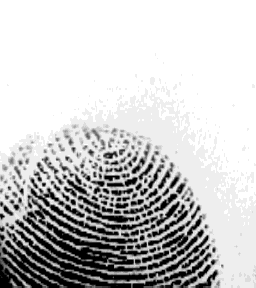

Gx,Gy
,

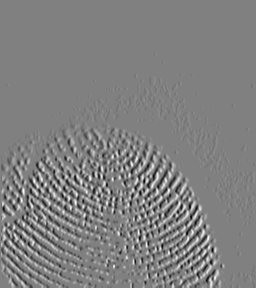
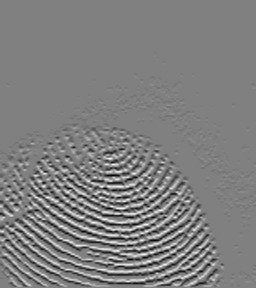

Gx**2,Gy**2,Gradient magnitude
,,

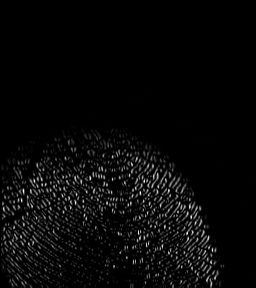
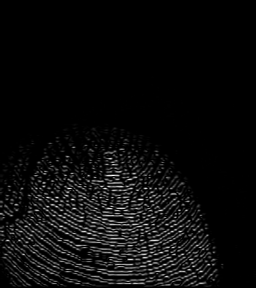
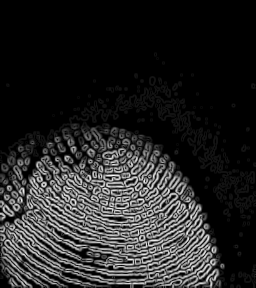

Integral of the gradient magnitude
""

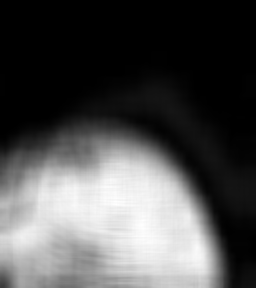

,,
,,

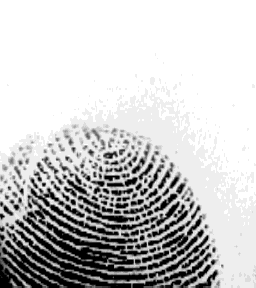
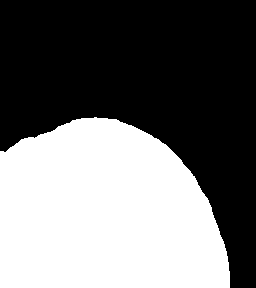
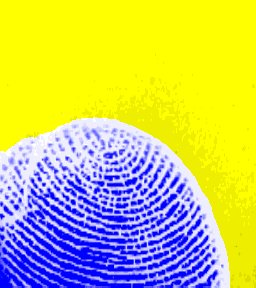

Orientation image
""

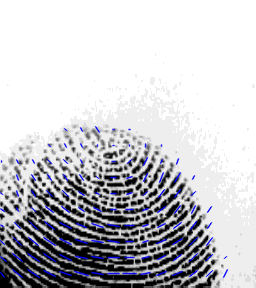

""
""

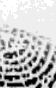

[13926 13917 13910 13880 13848 13835 13812 13790 13740 13709 13630 13566
 13512 13499 13482 13478 13471 13456 13449 13421 13395 13375 13339 13289
 13249 13210 13158 13056 12831 12590 12441 12349 12272 12328 12372 12329
 12272 12191 12008 11767 11456 11208 11127 11102 11106 11179 11192 11137
 11124 11040 10773 10237  9641  9187  8950  8890  9083  9339  9350  9168
  8928  8634  8502  8610  8785  8872  8745  8259  7665  7350  7562  8062
  8617  8781  8312  7576  6919  6483  6493  6874  6954  6580  6022  5492
  5453  6205  6692  6798]


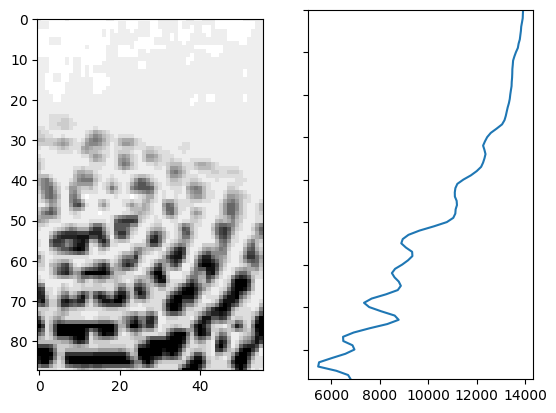

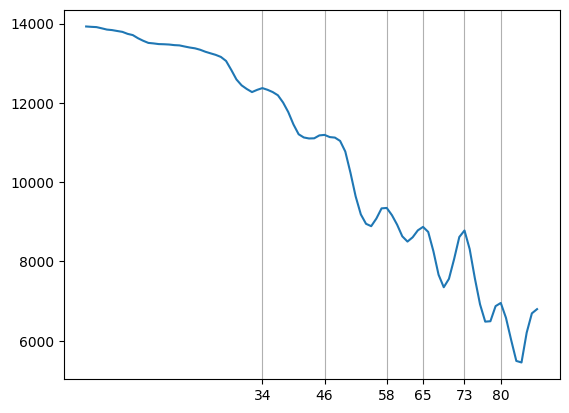

[12 12  7  8  7]
9.2


,,,,,,,
,,,,,,,

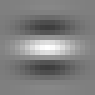
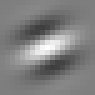
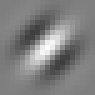
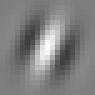
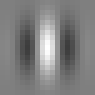
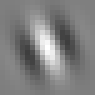
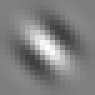
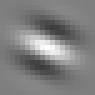

,,,,,,,,
,,,,,,,,

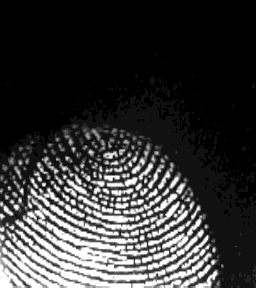
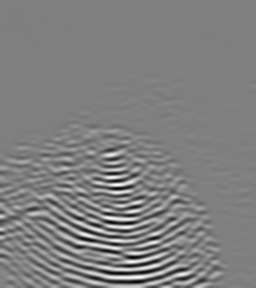
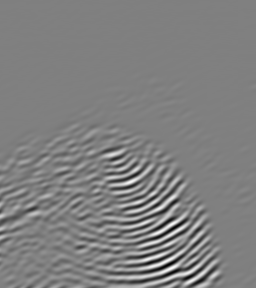
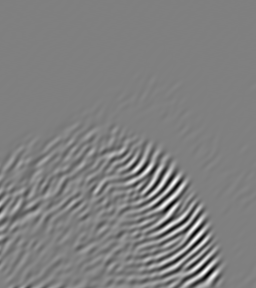
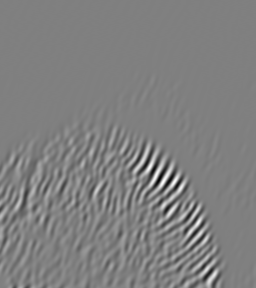
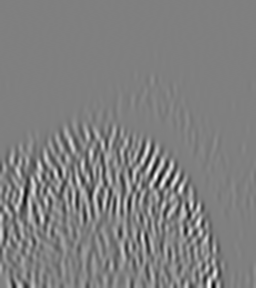
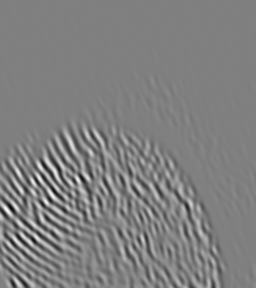
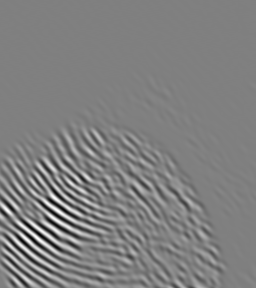
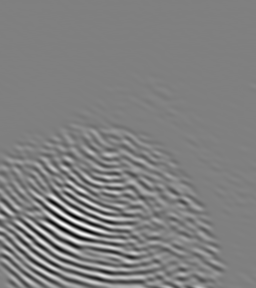

TypeError: unsupported operand type(s) for %: 'tuple' and 'float'

In [32]:
path1='/home/sg/Documents/projects/hoptal/biometric/data/by folder/18/Sherr_R_R.bmp'
path2='/home/sg/Documents/projects/hoptal/biometric/data/by folder/18/Sherr_R_R(1).bmp'
f1, m1, ls1, rcc1=everything(path1)
f2, m2, ls2, rcc2=everything(path2)
score=compare(f1, f2, m1, m2, ls1, ls2, rcc1, rcc2)